The copy of H-Siena Aug 26 to try the other model to descibe data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import emcee

In [3]:
import corner

In [4]:
import astropy.io.fits as fits

In [5]:
#load data 
data = fits.getdata('/data/lemn/results/NGC_Magz.fits')

In [6]:
N_GC = data['NGCs']
Mag_z = data['Mag z']

In [7]:
err_GC = data['err GC']

In [8]:
a = np.argwhere(~np.isnan(Mag_z)) #find idx of non nan values in Mag z

In [9]:
print(len(a), len(Mag_z))

289 297


In [10]:
N_GC   = N_GC[a]
Mag_z  = Mag_z[a]
err_GC = err_GC[a]
#print(Mag_z)

In [11]:
#reshape from nx1 to n-dimensions array
N_GC   = N_GC.reshape((len(a)))
Mag_z  = Mag_z.reshape((len(a)))
err_GC = err_GC.reshape((len(a)))

In [12]:
print(len(N_GC))

289


(array([47., 54., 57., 52., 53.,  9., 13.,  1.,  0.,  3.]),
 array([-24.55869691, -22.96800003, -21.37730315, -19.78660626,
        -18.19590938, -16.6052125 , -15.01451561, -13.42381873,
        -11.83312185, -10.24242496,  -8.65172808]),
 <BarContainer object of 10 artists>)

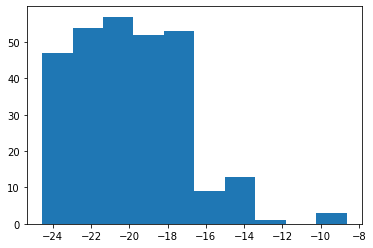

In [13]:
plt.hist(Mag_z)

In [14]:
nn = len(N_GC)
N_new   = np.zeros(nn) 
err_new = np.zeros(nn)
Mag_new = np.zeros(nn)
for i in range(0,nn):
    N_new[i] = N_GC[i]
    err_new[i] = err_GC[i]
    Mag_new[i] = Mag_z[i]

In [15]:
#try remove scatter points
for i in range (0,len(N_GC)):
    if N_GC[i] < 1e2 and Mag_z[i] < -23 :
        print(i)
        N_new = np.delete(N_new,i)
        err_new = np.delete(err_new,i)
        Mag_new = np.delete(Mag_new,i)

148


<ErrorbarContainer object of 3 artists>

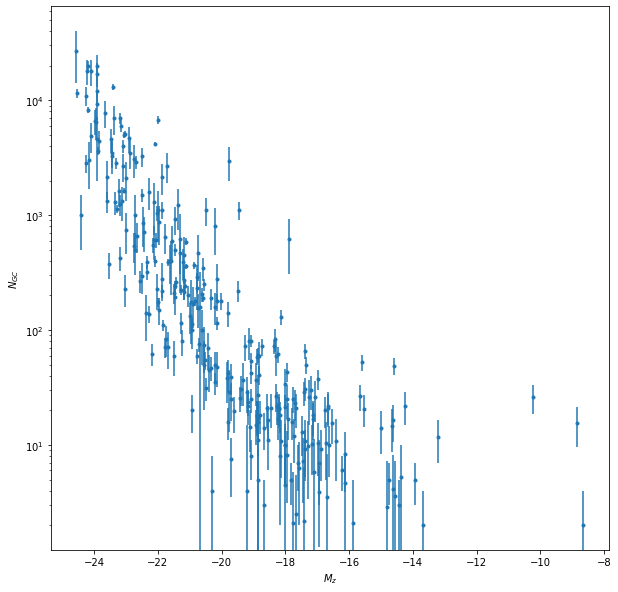

In [16]:
plt.figure(figsize=(10,10))
plt.xlabel('$M_z$')
plt.ylabel('$N_{GC}$')
plt.yscale('log')
#plt.xlim(-25,-15)
#plt.errorbar(Mag_z, N_GC, yerr = err_GC,fmt='.')
plt.errorbar(Mag_new, N_new, yerr = err_new,fmt='.')


try this model $y(x) = e^{-(\alpha x+b)}$

In [17]:
def model(para, mag=Mag_z): #para = all parameters in the model, mag = x axis
    alpha,b = para 
    model =  10**(-(alpha*mag + b))
    return model

 a, b = para define a function that return how good a fit our model is to the data, for the given set of parameters, weighted by the error in the data points (simple $\chi^2$ type check). 

\begin{align}
    L_{lnlike} = -0.5\sum \left(\frac{y-y_{model}}{y_{err}}\right)^2
\end{align}

- If the new model returns better fit compare to the default model (by an acceptance ratio), the walker will move toward that and repeat the process.

- Every walker keeps a record of $\theta$ and the likelihood of the model given data at value $\theta$.

- As if MCMC runs long enough to converge, it represents a sample of reasonable models to describe the data;



In [18]:
def lnlike(para, mag, y, yerr):
    lnlike = -0.5*np.sum(((y-model(para,mag))/yerr)**2)
    return lnlike

In [19]:
# the things we know (fact/conditions to the parameters)
def lnprior(para):
    alpha, b = para 
    if  0.4 < alpha <0.7 and 5 < b < 10: 
         return 0.0
    else:
        return -np.inf

In [20]:
# the function as lnprior output + lnlike output
def lnprob(para, mag, y, yerr):
    lp = lnprior(para)
    if not np.isfinite(lp): #check if input prior satisfy the parameter space
        return -np.inf
    return lp + lnlike(para, mag, y, yerr)

In [21]:
data     = (Mag_new, N_new, err_new) #(Mag_z, N_GC, err_GC)
nwalkers = 500
niter    = 10000
initial  = np.array([0.55, 6.6]) # initial set of values of the parameters (guess)
ndim     = len(initial)

In [22]:
# A list of the initial positions of the walkers in the parameter space. It should have the shape ``(nwalkers, dim)
#stepping from one place to the next, generate N-dimensional parameters space close to the current location
p0       = [np.array(initial) + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

In [23]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim,lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [24]:
#run emcee to get posterior (pos), probability, state(?)
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


        At each iteration, this generator yields:

        * ``pos`` - A list of the current positions of the walkers in the
          parameter space. The shape of this object will be
          ``(nwalkers, dim)``.

        * ``lnprob`` - The list of log posterior probabilities for the
          walkers at positions given by ``pos`` . The shape of this object
          is ``(nwalkers, dim)``.


In [25]:
print('current positions of walkers')
print(pos)

current positions of walkers
[[0.40366674 6.52451651]
 [0.40957341 6.662342  ]
 [0.4005168  6.45614983]
 [0.41448757 6.76867136]
 [0.40235228 6.50373148]
 [0.40214201 6.48175866]
 [0.40679541 6.60185989]
 [0.40199401 6.4991593 ]
 [0.40054185 6.46039663]
 [0.4051873  6.54585464]
 [0.4048406  6.53890412]
 [0.40968037 6.64926299]
 [0.40574082 6.55605342]
 [0.40011178 6.45514926]
 [0.40390457 6.54260809]
 [0.40471432 6.55841446]
 [0.400788   6.47791905]
 [0.40179611 6.49574774]
 [0.40128639 6.47482343]
 [0.40362514 6.52075212]
 [0.40193771 6.4914966 ]
 [0.40006869 6.45598029]
 [0.40232403 6.4985481 ]
 [0.40232428 6.49059394]
 [0.41474635 6.77126758]
 [0.41258684 6.73046684]
 [0.40151574 6.49862473]
 [0.40501148 6.5448259 ]
 [0.40316789 6.50916802]
 [0.40139757 6.48518679]
 [0.4029552  6.51733695]
 [0.40055434 6.45942329]
 [0.40865401 6.63229479]
 [0.40664213 6.58594534]
 [0.40165687 6.48830643]
 [0.40416469 6.53089391]
 [0.41391554 6.74575378]
 [0.40073839 6.45960144]
 [0.40887244 6.644249

In [26]:
print(np.max(prob))

-2966.1303091037935


In [27]:
def plotter(sampler,mag=Mag_new, N=N_new):
    plt.ion()
    plt.figure(figsize=(30,10))
    plt.yscale("log")   
    plt.errorbar(mag,N, yerr = err_new,fmt='.',label='data')
    #plt.plot(Mag_z,10**(-(0.5*Mag_z+8)),'r.', label='expected model')
    samples = sampler.flatchain
    for para in samples[np.random.randint(len(samples), size=10)]:
        plt.plot(mag, model(para, mag), '.',color='grey', alpha=0.3)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('$M_z$')
    plt.ylabel('$N_{GC}$')
    plt.legend()
    plt.show()

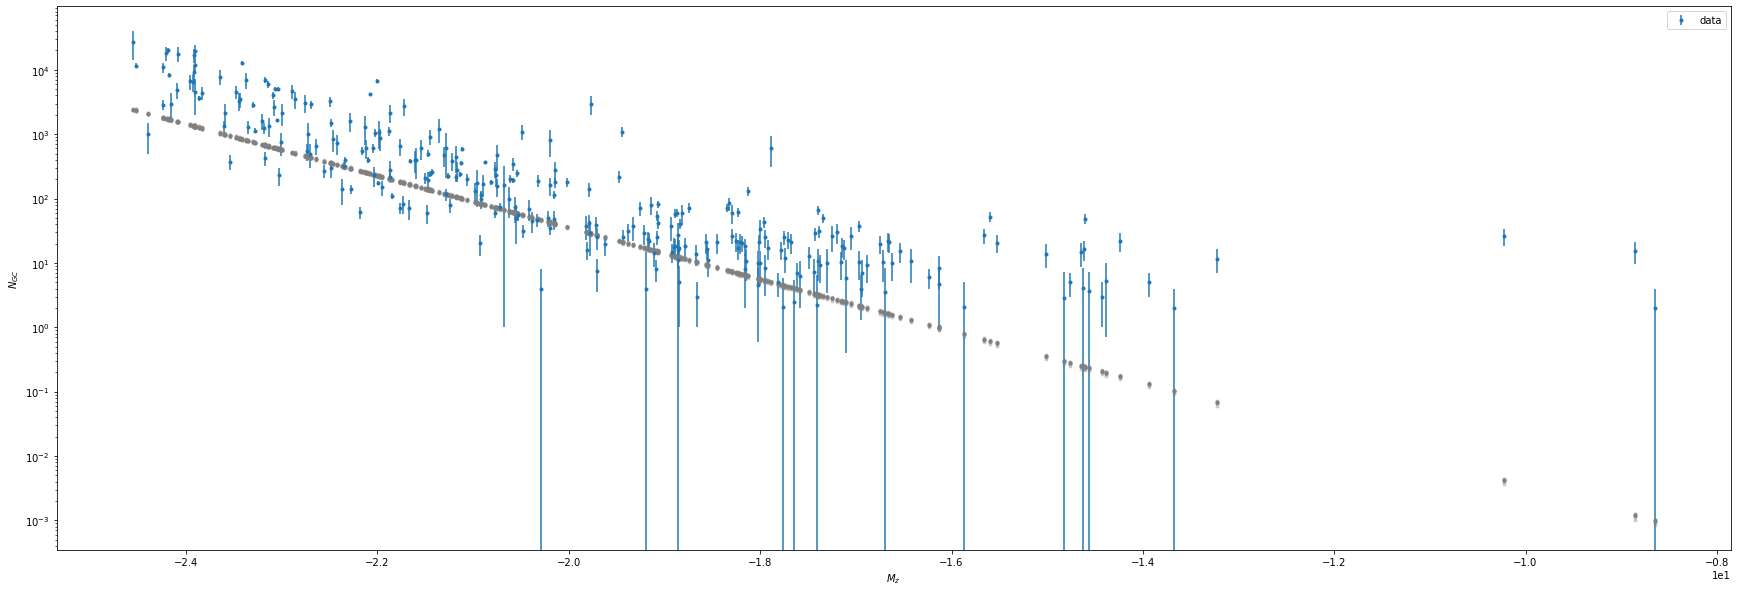

In [28]:
plotter(sampler)

Text(0.5, 0, 'step number')

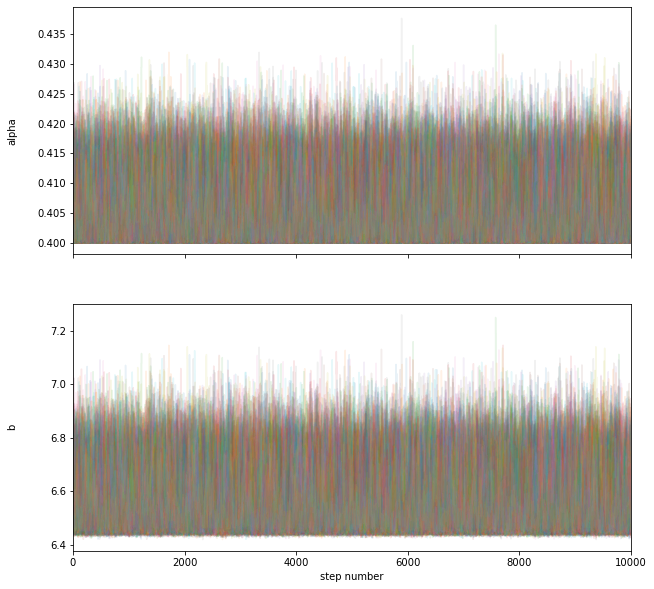

In [29]:
fig, axes = plt.subplots(2, figsize=(10, 10), sharex=True)
samples = sampler.get_chain()
labels = ['alpha','b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i],alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [30]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.674


Text(0, 0.5, 'acceptance fraction')

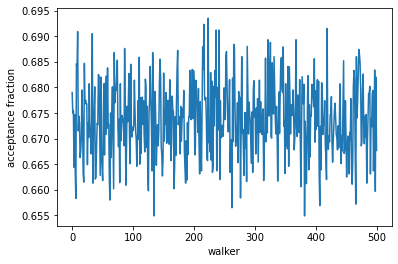

In [31]:
plt.plot(sampler.acceptance_fraction, '-')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')

In [32]:
print("Mean autocorrelation time: {0:.3f} steps".format(np.mean(sampler.get_autocorr_time())))

Mean autocorrelation time: 39.065 steps


In [33]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]
#value of each parameter, highest likelihood model 

array([0.40000007, 6.44735935])

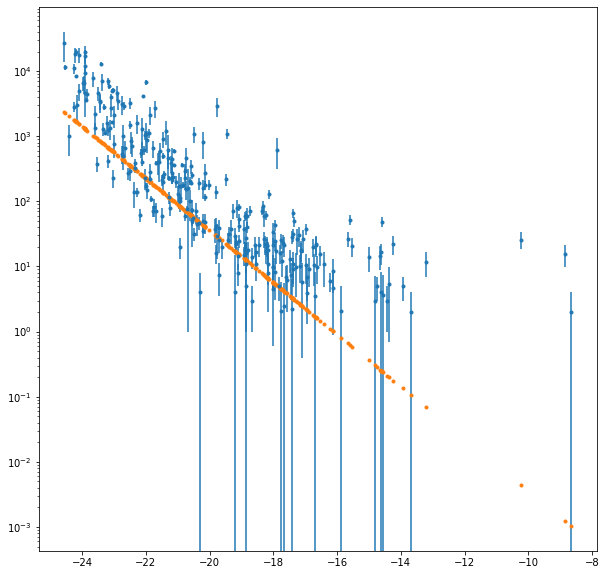

para max:  [0.40000007 6.44735935]


In [34]:
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max,Mag_new)
plt.figure(figsize=(10,10))
plt.errorbar(Mag_new,N_new,yerr=err_new,fmt='.')
plt.plot(Mag_new,best_fit_model,'.',label='Highest Likelihood Model')
plt.yscale("log")
#plt.ylim(0,100)
plt.show()
print ('para max: ',theta_max)

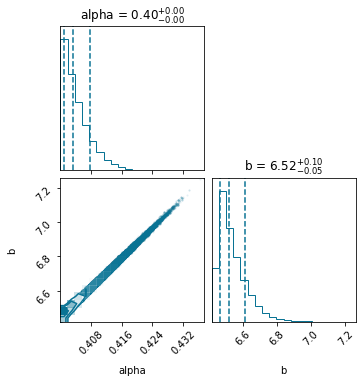

In [35]:
#posterior spread
fig = corner.corner(samples,show_titles=True,color='#097394',labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
#fig = corner.corner(samples,show_titles=True,color='#097394',labels=labels, plot_datapoints= False,smooth=True,quantiles=[0.16, 0.5, 0.84])